# Point Net Segmentation

This notebook will explore the Segmentation head of Point Net using the reduced and paritioned version of S3DIS dataset. This version is similar to the one used by torch geometry except that we will have to normalize and sample data on the fly. 

#### **Current State: Mildly Chaotic**

#### TODO:
- ensure that everything else is organized
- Continue training and testing
- Add descriptive analytics for dataset to help with understanding and training
- Add intuitive explainations and theory as needed

TEMP NOTE

use "git reset HEAD~1" to go back one commit

https://stackoverflow.com/questions/20002557/how-to-remove-a-too-large-file-in-a-commit-when-my-branch-is-ahead-of-master-by

In [1]:
import os
import re
from glob import glob
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torchmetrics.classification import MulticlassMatthewsCorrCoef
import open3d as o3
# from open3d import JVisualizer # For Colab Visualization
from open3d.web_visualizer import draw # for non Colab

import matplotlib.pyplot as plt
%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
# TEMP for supressing pytorch user warnings
import warnings
warnings.filterwarnings("ignore")

Initialize variables for entire notebook

In [4]:
# dataset
ROOT = r'C:\Users\itber\Documents\datasets\S3DIS\Stanford3dDataset_v1.2_Reduced_Partitioned_Aligned_Version'
NUM_CLASSES = 14

# feature selection hyperparameters
NUM_TRAIN_POINTS = 4096 # train/valid points
NUM_TEST_POINTS = 10000

# training hyperparameters
BATCH_SIZE = 16
EPOCHS = 50
LR = 0.01
REG_WEIGHT = 0.001 # factor to scale regularization term

See: https://www.mathworks.com/help/vision/ug/point-cloud-classification-using-pointnet-deep-learning.html

In [5]:
CATEGORIES = {
    'ceiling'  : 0, 
    'floor'    : 1, 
    'wall'     : 2, 
    'beam'     : 3, 
    'column'   : 4, 
    'window'   : 5,
    'door'     : 6, 
    'table'    : 7, 
    'chair'    : 8, 
    'sofa'     : 9, 
    'bookcase' : 10, 
    'board'    : 11,
    'stairs'   : 12,
    'clutter'  : 13
}

# unique color map generated via
# https://mokole.com/palette.html
COLOR_MAP = {
    0  : (47, 79, 79),    # ceiling - darkslategray
    1  : (139, 69, 19),   # floor - saddlebrown
    2  : (34, 139, 34),   # wall - forestgreen
    3  : (75, 0, 130),    # beam - indigo
    4  : (255, 0, 0),     # column - red 
    5  : (255, 255, 0),   # window - yellow
    6  : (0, 255, 0),     # door - lime
    7  : (0, 255, 255),   # table - aqua
    8  : (0, 0, 255),     # chair - blue
    9  : (255, 0, 255),   # sofa - fuchsia
    10 : (238, 232, 170), # bookcase - palegoldenrod
    11 : (100, 149, 237), # board - cornflower
    12 : (255, 105, 180), # stairs - hotpink
    13 : (0, 0, 0)        # clutter - black
}

v_map_colors = np.vectorize(lambda x : COLOR_MAP[x])

#### Get Datasets and Dataloaders

In [6]:
from torch.utils.data import DataLoader
from s3dis_dataset import S3DIS

# get datasets
s3dis_train = S3DIS(ROOT, area_nums='1-4', npoints=NUM_TRAIN_POINTS)
s3dis_valid = S3DIS(ROOT, area_nums='5', npoints=NUM_TRAIN_POINTS)
s3dis_test = S3DIS(ROOT, area_nums='6', split='test', npoints=NUM_TEST_POINTS)

# get dataloaders
train_dataloader = DataLoader(s3dis_train, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(s3dis_valid, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(s3dis_test, batch_size=BATCH_SIZE, shuffle=False)

Get an example and display it

In [6]:
points, targets = s3dis_train[1000]

pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(points)
pcd.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(targets)).T/255)

draw(pcd)

WebVisualizer(window_uid='window_0')

#### Investigate class distributions in the Training dataset

NOTE: If you take a look at the S3DIS dataset class, you will notice that samples with less points than npoints are sampled with replacement. This means that some points will be oversampled. This will lead to a variable class balance eachtime the dataloader is called. However, you can run these cells many times and see that we will nearly always have the same ratios of classes.

In [7]:
total_train_targets = []
for (_, targets) in train_dataloader:
    total_train_targets += targets.reshape(-1).numpy().tolist()

total_train_targets = np.array(total_train_targets)

Plot Barchart of category counts

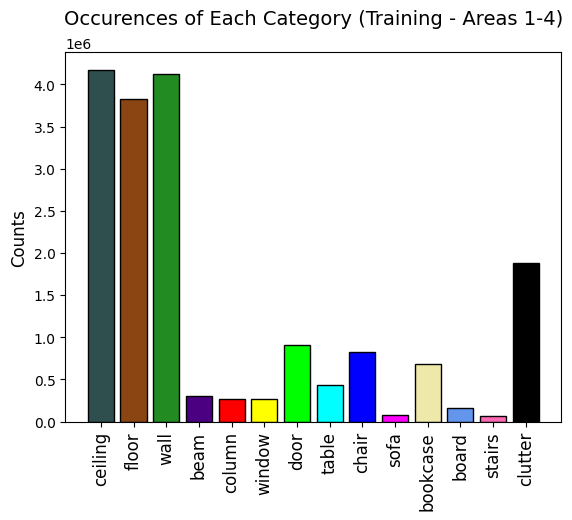

In [8]:
class_bins = np.bincount(total_train_targets)

plt.bar(list(CATEGORIES.keys()), class_bins, 
             color=[np.array(val)/255. for val in list(COLOR_MAP.values())],
             edgecolor='black')
plt.xticks(list(CATEGORIES.keys()), list(CATEGORIES.keys()), size=12, rotation=90)
plt.ylabel('Counts', size=12)
plt.title('Occurences of Each Category (Training - Areas 1-4)', size=14, pad=20);

We can see that this dataset is heavily imbalanced, the more common items such as ceiling, floor, and wall greatly outnumber all of the other categories. These classes are actually background classes. If we were to train using a loss such as Cross Entropy, we would consider each class to have an equal importance. Meaning, missclassifyng window is trreated the same as misclassifying wall. In reality, we would want our model to focus more on the uncommon categories and not care so much about the common ones. We have a priori knowledge that structures such as ceiling, wall, and floor are continuous and if we look at some training examples, we will see that they are like large sheets. If we were to only classify 60% of these, we would still be in pretty good shape. However, if we classify only 60% of the other less common classes, we may run into some serious generalization issues. One way to overcome the class imbalance is to use a weighted loss function. This will essentially tell the model (during training) to focus more on particular classes that it gets wrong (hard examples) and to focus less on the classes it tends to get right (easy examples).

*SIDE NOTE:*
*With the notion that certain classes have unique structures, it may be more effective to perform object recognition as opposed to segmentation. Or use some sort of object recognition to augment the segmentation model and form some sort of ensemble.*

The loss that we will use is called the [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf), it is a modified version of the Cross Entropy (CE) loss that is useful for imbalanced classification, it focuses the training on a sparse set of hard examples. 

We will also try to use the [Dice Loss](https://arxiv.org/pdf/1707.03237v3.pdf) and compare results

#### Focal Loss Notes:
- it focuses training on a sparse set of hard examples
- Predictions with Probability >> 0.5 are easy examples and they should not have a high loss
   - This is because summing the losses of many easy examples will quickly overwhelm the loss of the few hard examples
-

The Focal Loss is a modified Cross Entropy (CE) Loss. The CE Loss for a sample $n$ is given below. 

$$ CE(s_n, y_n) = -\alpha_{y_n} log \left( \frac{exp(\mathbf{s_n})}{\sum_{c=1}^M exp(s_{n,c})} \right) \mathbf{1}_C(y_n) $$

Where $\mathbf{s_n}$ is the predicted class score vector (logits), $M$ is the number of classes, $y_n$ is the true class, $\alpha_{y_n}$ is the class weight, and $\mathbf{1}_C(y_n)$ is the [Indcator Function](https://en.wikipedia.org/wiki/Indicator_function) that tells us to only consider the prediction for the current class $y_n$. <br>
$e.g.$ if $\mathbf{s_n} = [0.02, 0.142, 0.356, 0.0012, 0.0456]$ and $y_n = 3$, then $\mathbf{s_n}  \mathbf{1}_C(y_n) = 0.0012$ (NOTE: we used zero indexing here).

We may also notice that the term inside the $log$ is the Softmax function, which along wth the indicator function, gives us the predicted class probability. We can rewrite the CE Loss in a more simple format as:
$$ CE(p_n) = -\alpha_{y_n} log(p_n)  $$
Where the $n$ subscript refers to the true class at sample $n$.

<br> 
The CE loss is typically unweighted, but if a weight is used it is reffered to as the Balanced (or Weighted) CE Loss. The weights are usually based on inverse class distribution and typically range from [0, 1]. The weights can also be set as a hyperparameter via Cross Validation.

$$ \mathbf{\alpha} = \frac{1}{\text{class counts}} $$
We may also normalize alpha so that it spreads between [0,1]
$$ \alpha = \frac{\alpha}{\max{\alpha}} $$


<br>

The Focal Loss adds an additional modulating factor to the weighted CE Loss: $ (1 - p_n)^\gamma $, where $\gamma \geq 0$ is referred to as the focusing parameter. This term has tends to 0 when the prediction probability is high, and has a larger value when the prediction probability is lower forcing the model to focus on the hard examples. It can be said that the focusing parameter smoothly adjusts the rate at which easy examples are down-weighted. We can formally express the Focal Loss as:

$$ FL(p_n) = -\alpha_{y_n} (1 - p_n)^\gamma log(p_n)  $$

<br> Summary: <br>
- The Focal Loss is a modified version of the Balanced Cross Entropy Loss
- The class weight $\alpha$ balances the importance of loss values based class distribution
- The modulating term forces the model to focus on the hard examples by downweighting the easy examples
increasing the loss of predictions with lower probability.
- The class weights $\alpha$ and focusing parameter $\gamma$ are hyperparameters that can be tuned 

<br>
Sources: <br>

- https://gombru.github.io/2018/05/23/cross_entropy_loss/ 
- https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
- https://hasty.ai/docs/mp-wiki/loss/focal-loss
- https://arxiv.org/pdf/1708.02002.pdf

### Get Segmentation Version of Point Net
Make a test forward pass

In [9]:
points, targets = next(iter(train_dataloader))
points.shape

torch.Size([16, 4096, 3])

In [10]:
from point_net import PointNetSegHead

seg_model = PointNetSegHead(num_points=NUM_TRAIN_POINTS, m=NUM_CLASSES)
out, _, _ = seg_model(points.transpose(2, 1))
print(f'Seg shape: {out.shape}')

Seg shape: torch.Size([16, 4096, 14])


## Start Training

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

We will use a pytorch implementation of the focal loss based on code from this [repository](https://github.com/clcarwin/focal_loss_pytorch/blob/master/focalloss.py)

In [12]:
from torch.autograd import Variable


class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=0, size_average=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.size_average = size_average

        # sanitize inputs
        if isinstance(alpha,(float, int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,(list, np.ndarray)): self.alpha = torch.Tensor(alpha)

        # get Balanced Cross Entropy Loss
        self.cross_entropy_loss = nn.CrossEntropyLoss(weight=self.alpha)
        

    def forward(self, predictions, targets):

        # get Balanced Cross Entropy Loss
        ce_loss = self.cross_entropy_loss(predictions, targets)

        # reformat predictions and targets
        predictions = predictions.transpose(1, 2) # (b, c, n) -> (b, n, c)
        predictions = predictions.contiguous().view(-1, predictions.size(2)) # (b, n, c) -> (b*n, c)

        # get log softmax of predictions
        log_pn = F.log_softmax(predictions)

        # get predictions at true class indexes
        log_pn = log_pn.gather(1, targets.view(-1,1)).view(-1) # index log softmax values at targets

        # get predicted probabilities
        pn = Variable(log_pn.data.exp())

        # compute loss (negative sign is included in ce_loss)
        loss = (1 - pn)**self.gamma * ce_loss
        if self.size_average: return loss.mean()
        else: return loss.sum()

Compute $\alpha$ as the normalized inverse class frequency.

Instead compute alpha roughly based on class frequencies

In [16]:
alpha = 1 / class_bins
alpha = (alpha/alpha.max())

# alpha = np.ones(len(CATEGORIES))
# alpha[0:3] *= 0.25 # balance background classes
# alpha[-1] *= 0.75  # balance clutter class

alpha

array([0.0169883 , 0.01856612, 0.01721732, 0.23874722, 0.2709244 ,
       0.26508841, 0.07790794, 0.16175978, 0.08572105, 0.91351414,
       0.10325402, 0.43853849, 1.        , 0.03763789])

Load model from disk if necessary

In [ ]:
MODEL_PATH = 'seg_focal/seg_model_21.pth'

seg_model = PointNetSegHead(num_points=NUM_TRAIN_POINTS, m=NUM_CLASSES).to(device)
seg_model.load_state_dict(torch.load(MODEL_PATH))

Get Optimizer and Criterion

In [17]:
import torch.nn as nn 
import torch.optim as optim
if torch.cuda.is_available():
    import torch.backends.cudnn as cudnn

optimizer = optim.Adam(seg_model.parameters(), lr=0.01)
# criterion = FocalLoss(gamma=1, alpha=alpha)
# criterion = FocalLoss(alpha=alpha, gamma=0.)
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(alpha)).to(device)

seg_model = seg_model.to(device)

For our training we will want to quantify how well our model is performing. Typically we look at loss and accuracy, but for this segmentation problem we will need a mteric that accounts for incorrect classifcation as well as correct classification. The Matthews Correlation Coefficent does this and we will use it to quantify our performance. The MCC ranges from -1 to 1, to understand what the MCC is reporting:
- 0 indicates a random guess
- -1 is the worst possible performance
- 1 is the best possible performance

In [18]:
mcc_metric = MulticlassMatthewsCorrCoef(num_classes=NUM_CLASSES).to(device)

NOTE: In the original TensorFlow implementation, the regularization term is not used to train the sematic segmentation model.

In [19]:
# stuff for training
num_train_batch = len(s3dis_train)/BATCH_SIZE 
num_valid_batch = len(s3dis_valid)/BATCH_SIZE 

# store best validation mcc
best_mcc = -np.infty

# lists to store metrics
train_loss = []
train_accuracy = []
train_mcc = []
valid_loss = []
valid_accuracy = []
valid_mcc = []

for epoch in range(1, EPOCHS + 1):
    # place model in training mode
    seg_model = seg_model.train()
    _train_loss = []
    _train_accuracy = []
    _train_mcc = []
    for i, (points, targets) in enumerate(train_dataloader, 0):

        points = points.transpose(2, 1).to(device)
        targets = targets.squeeze().to(device)
        
        # zero gradients
        optimizer.zero_grad()
        
        # get predicted class logits
        preds, _, A = seg_model(points)
        
        # compute regularization term to enforce orthogonality on the feature Transformation
        # I = torch.eye(64).unsqueeze(0).repeat(A.shape[0], 1, 1).to(device)
        # reg = torch.linalg.norm(I - torch.bmm(A, A.transpose(2, 1)))

        # get loss and perform backprop
        loss = criterion(preds.transpose(2, 1), targets) # + REG_FACTOR*reg/preds.size(0)
        loss.backward()
        optimizer.step()
        
        # get class predictions
        pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)
        correct = pred_choice.eq(targets.data).cpu().sum()
        accuracy = correct/float(BATCH_SIZE*NUM_TRAIN_POINTS)
        mcc = mcc_metric(preds.transpose(2, 1), targets)

        # update epoch loss and accuracy
        _train_loss.append(loss.item())
        _train_accuracy.append(accuracy)
        _train_mcc.append(mcc.item())

        if i % 100 == 0:
            print('\t [%d: %d/%d] train loss: %f accuracy: %f mcc: %f' \
                  % (epoch, i, num_train_batch, loss.item(), accuracy, mcc))
        
    train_loss.append(np.mean(_train_loss))
    train_accuracy.append(np.mean(_train_accuracy))
    train_mcc.append(np.mean(_train_mcc))

    print(f'Epoch: {epoch} - Train Loss: {train_loss[-1]} ' \
          + f'- Train Accuracy: {train_accuracy[-1]} ' \
          + f'- Train MCC: {train_mcc[-1]}')

    # pause to cool down
    time.sleep(8)

    # get test results after each epoch
    with torch.no_grad():

        # place model in evaluation mode
        seg_model = seg_model.eval()

        _valid_loss = []
        _valid_accuracy = []
        _valid_mcc = []
        for i, (points, targets) in enumerate(valid_dataloader, 0):

            points = points.transpose(2, 1).to(device)
            targets = targets.squeeze().to(device)

            preds, _, A = seg_model(points)

            # compute regularization term to enforce orthogonality on the feature Transformation
            # I = torch.eye(64).unsqueeze(0).repeat(A.shape[0], 1, 1).to(device)
            # reg = torch.linalg.norm(I - torch.bmm(A, A.transpose(2, 1)))

            loss = criterion(preds.transpose(2, 1), targets) # + REG_FACTOR*reg/preds.size(0)

            pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)
            correct = pred_choice.eq(targets.data).cpu().sum()
            accuracy = correct/float(BATCH_SIZE*NUM_TRAIN_POINTS)
            mcc = mcc_metric(preds.transpose(2, 1), targets)

            # update epoch loss and accuracy
            _valid_loss.append(loss.item())
            _valid_accuracy.append(accuracy)
            _valid_mcc.append(mcc.item())

            if i % 100 == 0:
                print('\t [%d: %d/%d] %s loss: %f accuracy: %f mcc: %f' \
                      % (epoch, i, num_valid_batch, 'validation', loss.item(), accuracy, mcc))
        
        valid_loss.append(np.mean(_valid_loss))
        valid_accuracy.append(np.mean(_valid_accuracy))
        valid_mcc.append(np.mean(_valid_mcc))
        print(f'Epoch: {epoch} - Validation Loss: {valid_loss[-1]} ' \
              + f'- Validation Accuracy: {valid_accuracy[-1]} ' \
              + f'- Validation MCC: {valid_mcc[-1]}')

        # pause to cool down
        time.sleep(8)

    # save best models
    if valid_mcc[-1] >= best_mcc:
        best_mcc = valid_mcc[-1]
        torch.save(seg_model.state_dict(), f'seg_balanced/seg_model_{epoch}.pth')

	 [1: 0/274] train loss: 2.706010 accuracy: 0.032700 mcc: -0.059285
	 [1: 100/274] train loss: 2.428142 accuracy: 0.224121 mcc: 0.185446
	 [1: 200/274] train loss: 2.030124 accuracy: 0.380005 mcc: 0.344859
Epoch: 1 - Train Loss: 2.318133294365623 - Train Accuracy: 0.29226788878440857 - Train MCC: 0.24166013719027185
	 [1: 0/145] validation loss: 2.342360 accuracy: 0.392273 mcc: 0.362461
	 [1: 100/145] validation loss: 2.839006 accuracy: 0.371857 mcc: 0.310871
Epoch: 1 - Validation Loss: 161.74886017547894 - Validation Accuracy: 0.32705041766166687 - Validation MCC: 0.28094938509676554
	 [2: 0/274] train loss: 2.003289 accuracy: 0.348145 mcc: 0.295233
	 [2: 100/274] train loss: 2.269238 accuracy: 0.366806 mcc: 0.320506
	 [2: 200/274] train loss: 1.500870 accuracy: 0.425308 mcc: 0.382096
Epoch: 2 - Train Loss: 1.9275375838713213 - Train Accuracy: 0.3993002474308014 - Train MCC: 0.35617120135914193
	 [2: 0/145] validation loss: 2.079919 accuracy: 0.423721 mcc: 0.374401
	 [2: 100/145] vali

KeyboardInterrupt: 

Let's plot the training metrics

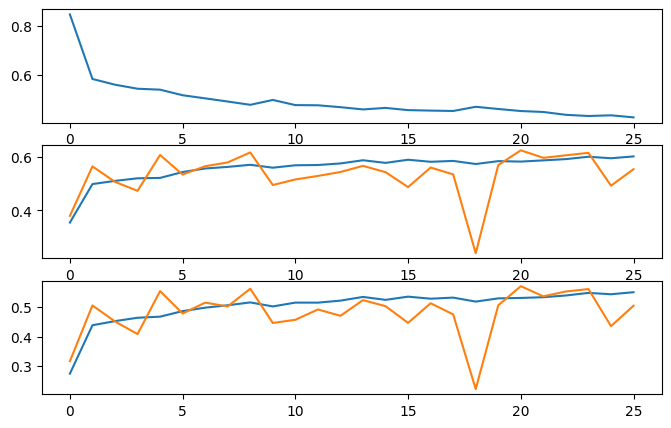

In [21]:
_, ax = plt.subplots(3, 1, figsize=(8, 5))
ax[0].plot(train_loss)
# ax[0].plot(valid_loss)

ax[1].plot(train_accuracy)
ax[1].plot(valid_accuracy)

ax[2].plot(train_mcc)
ax[2].plot(valid_mcc)

In [245]:
np.argmax(valid_mcc)

49

### Test the model

Upload model from disk. The best model was 21 (actually 22 since we need to account for zero indexing)

In [22]:
MODEL_PATH = 'seg_focal/seg_model_21.pth'

model = PointNetSegHead(num_points=NUM_TEST_POINTS, m=NUM_CLASSES).to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval();

#### Implement Quick test to gather metrics

In [23]:
num_test_batch = len(s3dis_test)/BATCH_SIZE 

total_test_targets = []
total_test_preds = [] 

with torch.no_grad():

    # place model in evaluation mode
    model = model.eval()

    test_loss = []
    test_accuracy = []
    test_mcc = []
    for i, (points, targets) in enumerate(test_dataloader, 0):

        points = points.transpose(2, 1).to(device)
        targets = targets.squeeze().to(device)

        preds, _, A = model(points)

        # compute regularization term to enforce orthogonality on the feature Transformation
        # I = torch.eye(64).unsqueeze(0).repeat(A.shape[0], 1, 1).to(device)
        # reg = torch.linalg.norm(I - torch.bmm(A, A.transpose(2, 1)))

        loss = criterion(preds.transpose(2, 1), targets) # + reg

        pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)
        correct = pred_choice.eq(targets.data).cpu().sum()
        accuracy = correct/float(BATCH_SIZE*NUM_TEST_POINTS)
        mcc = mcc_metric(preds.transpose(2, 1), targets)

        # update epoch loss and accuracy
        test_loss.append(loss.item())
        test_accuracy.append(accuracy)
        test_mcc.append(mcc.item())

        # add to total targets/preds
        total_test_targets += targets.reshape(-1).cpu().numpy().tolist()
        total_test_preds += pred_choice.reshape(-1).cpu().numpy().tolist()

        if i % 50 == 0:
            print('\t [%d/%d] test loss: %f accuracy: %f mcc: %f' \
                    % (i, num_test_batch, loss.item(), accuracy, mcc))

# display test results
print(f'Test Loss: {np.mean(test_loss)} ' \
        + f'- Test Accuracy: {np.mean(test_accuracy)} ' \
        + f'- Test MCC: {np.mean(test_mcc)}')

	 [0/71] test loss: 0.158591 accuracy: 0.841131 mcc: 0.810144
	 [50/71] test loss: 0.585894 accuracy: 0.612731 mcc: 0.557561
Test Loss: 712971307060.7778 - Test Accuracy: 0.5861029028892517 - Test MCC: 0.5303102020795146


In [24]:
total_test_targets = np.array(total_test_targets)
total_test_preds = np.array(total_test_preds)

#### Get Confusion Matrix for Test data

In [25]:
from sklearn.metrics import confusion_matrix

test_confusion = pd.DataFrame(confusion_matrix(total_test_targets, total_test_preds),
                              columns=list(CATEGORIES.keys()),
                              index=list(CATEGORIES.keys()))

test_confusion

,ceiling,floor,wall,beam,column,window,door,table,chair,sofa,bookcase,board,stairs,clutter
ceiling,2403292,3423,13542,12220,0,1026,13382,5546,0,4085,23150,6911,1707,13897
floor,6464,2160530,3,39,4,0,8699,4968,374,2913,1927,1809,0,604
wall,154857,34013,647568,17672,11396,100135,302437,72328,62286,14779,176640,547791,640,269558
beam,39506,0,160724,85554,0,0,133333,0,0,0,351,3243,0,46119
column,4214,7724,59697,5,4001,15422,137558,4417,1093,758,54283,30304,40,9769
window,1299,269,53663,3,0,124041,439,9538,127,5565,9202,10934,272,20170
door,0,15295,79928,4150,1109,46,396400,1021,2235,43,18532,86284,0,3693
table,0,11848,33801,0,0,1590,13379,284562,117668,21240,13891,3967,2077,14079
chair,0,36436,15789,0,0,0,23892,58272,282464,1472,2254,3808,0,17438
sofa,0,5020,1321,0,0,0,2050,8211,26291,3224,1217,1,0,540


#### View test results on full space

In [26]:
torch.cuda.empty_cache() # release GPU memory
points, targets = s3dis_test.get_random_partitioned_space()

# place on device
points = points.to(device)
targets = targets.to(device)

# Normalize each partitioned Point Cloud to (0, 1)
norm_points = points.clone()
norm_points = norm_points - norm_points.min(axis=1)[0].unsqueeze(1)
norm_points /= norm_points.max(axis=1)[0].unsqueeze(1)

with torch.no_grad():

    norm_points = norm_points.transpose(2, 1)
    targets = targets.squeeze()

    preds, _, A = model(norm_points)

    pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)
    correct = pred_choice.eq(targets.data).cpu().sum()
    accuracy = correct/float(points.shape[0]*NUM_TEST_POINTS)
    mcc = mcc_metric(preds.transpose(2, 1), targets)

Display the truth and predictions

In [27]:
pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(points.permute(2, 0, 1).reshape(3, -1).to('cpu').T)
pcd.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(targets.reshape(-1).to('cpu'))).T/255)

draw(pcd)

WebVisualizer(window_uid='window_0')

In [267]:
pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(points.to('cpu')[2, :, :])
pcd.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(targets.to('cpu')[2, :])).T/255)

draw(pcd)

WebVisualizer(window_uid='window_4')

In [28]:
pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(points.permute(2, 0, 1).reshape(3, -1).to('cpu').T)
pcd.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(pred_choice.reshape(-1).to('cpu'))).T/255)

draw(pcd)

WebVisualizer(window_uid='window_1')

In [266]:
pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(points.to('cpu')[2, :, :])
pcd.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(pred_choice.to('cpu')[2, :])).T/255)

draw(pcd)

WebVisualizer(window_uid='window_3')

### General Notes

It appears that not using the regularized loss leads to quicker training i.e. better performance with less epochs. Some more experimentation could be done to check if the regularization leads to superior performance over a longer training period.

It seems like the regularization term in the loss function greatly overpowers the loss. Causing the loss to blow up.